In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

import shap

import sys
sys.path.append("../src")

from manual_mappings import (
    eSituation_08_mapping,
    eSituation_07_mapping,
    eResponse_05_mapping,
    eSituation_13_mapping,
    ePayment_01_mapping,
    ePayment_50_mapping,
    eArrest_02_mapping,
    eArrest_05_mapping,
    eScene_08_mapping,
    eScene_06_mapping,
    eScene_09_mapping,
    first_route_mapping
)


In [2]:
import os
print(os.getcwd())


/Users/jake/Documents/Flatiron/phase_5/opiate_use_analysis/notebooks


In [3]:
# Load the merged dataset
df = pd.read_csv("../data/interim/opioid_cases_full.csv", low_memory=False)

print("Data loaded:", df.shape)

# Quick peek at columns
df.head()

Data loaded: (271206, 133)


,PcrKey,eDispatch_01,eDispatch_02,eArrest_14,eArrest_01,eArrest_02,eArrest_05,eArrest_07,eArrest_11,eArrest_16,...,ems_cpr,rosc_achieved,use_flag_count,unique_use_flags,all_use_flags,all_use_flags_str,symptom_count,unique_symptoms,all_symptoms,all_symptoms_str
0,225614082,~2301053 ~,~7701003 ~,~Not Applicable ~,~3001001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,...,False,False,1,1,['~8801015 '],~8801015,1.0,1.0,['~7701003 '],~7701003
1,225614423,~2301053 ~,~2302007 ~,~Not Applicable ~,~3001001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,...,False,False,1,1,['~8801023 '],~8801023,1.0,1.0,['~R11.10 '],~R11.10
2,225614880,~2301079 ~,~2302001 ~,~Not Applicable ~,~3001001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,...,False,False,1,1,['~8801015 '],~8801015,1.0,1.0,['~7701001 '],~7701001
3,225615710,~2301051 ~,~2302007 ~,~Not Applicable ~,~3001001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,...,False,False,1,1,['~8801015 '],~8801015,1.0,1.0,['~R44.3 '],~R44.3
4,225616308,~2301053 ~,~7701003 ~,~Not Applicable ~,~3001001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,~7701001 ~,...,False,False,1,1,['~3117007 '],~3117007,1.0,1.0,['~7701003 '],~7701003


In [4]:
# Strip tildes and spaces from all object columns
cols_to_clean = df.select_dtypes(include="object").columns

for col in cols_to_clean:
    df[col] = df[col].astype(str).str.strip(" ~")

print("Cleaned all string columns.")

Cleaned all string columns.


In [5]:
# Count missing values
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing_counts / len(df) * 100).round(2)

# Combine into a DataFrame
missing_summary = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent
}).query("`Missing Count` > 0")

print("Columns with missing values:", missing_summary.shape[0])
missing_summary.head(20)

Columns with missing values: 65


,Missing Count,Missing %
BGL_std,260563,96.08
ETCO2_std,227360,83.83
ETCO2_min,218952,80.73
ETCO2_last,218952,80.73
ETCO2_first,218952,80.73
ETCO2_mean,218952,80.73
ETCO2_max,218952,80.73
BGL_mean,124639,45.96
BGL_max,124639,45.96
BGL_min,124639,45.96


In [6]:
# Show outcome codes
print("eOutcome_01 value counts:")
print(df["eOutcome_01"].value_counts(dropna=False))

print("\neOutcome_02 value counts:")
print(df["eOutcome_02"].value_counts(dropna=False))

eOutcome_01 value counts:
eOutcome_01
7701003    223107
7701001     43323
01           1959
30           1197
09            779
07            271
02            216
65            139
21             85
70             38
20             28
03             19
04             17
06              7
66              7
05              6
62              6
63              1
61              1
Name: count, dtype: int64

eOutcome_02 value counts:
eOutcome_02
7701003    206880
7701001     61818
30           1049
01            915
07            155
65            100
02             77
06             54
70             36
20             29
62             27
03             19
05             14
21             11
66              6
51              5
04              5
50              3
63              2
61              1
Name: count, dtype: int64


In [7]:
# Define mapping for eOutcome codes
admit_codes = {
    "02",  # Transferred Hospital
    "03",  # Transferred SNF
    "04",  # Transferred ICF
    "05",  # Transferred Other
    "06",  # Home Health
    "09",  # Admitted Hospital
    "20",  # Deceased
    "21",  # Transferred Law Enforcement
    "30",  # Still Patient
    "50",  # Hospice Home
    "51",  # Hospice Facility
    "61",  # Swing Bed
    "62",  # Rehab Facility
    "63",  # Long-Term Care
    "64",  # Medicaid Nursing
    "65",  # Psychiatric Facility
    "66",  # Critical Access Hospital
    "70",  # Other Healthcare Facility
}

# Helper to check if admitted/transferred
def is_admitted(row):
    val1 = str(row["eOutcome_01"]).strip()
    val2 = str(row["eOutcome_02"]).strip()
    return int((val1 in admit_codes) or (val2 in admit_codes))

# Create binary column
df["Outcome_Admitted"] = df.apply(is_admitted, axis=1)

# Show counts
print("Binary outcome distribution (0 = Discharged/Refused, 1 = Admitted/Transferred):")
print(df["Outcome_Admitted"].value_counts(dropna=False))


Binary outcome distribution (0 = Discharged/Refused, 1 = Admitted/Transferred):
Outcome_Admitted
0    268520
1      2686
Name: count, dtype: int64


In [8]:
# Codes that mean "missing outcome"
missing_codes = {"7701001", "7701003"}

# Boolean mask: keep rows where at least one outcome field is not missing
mask_valid_outcome = ~(
    df["eOutcome_01"].isin(missing_codes) & df["eOutcome_02"].isin(missing_codes)
)

# Subset
df_model = df.loc[mask_valid_outcome].copy()

print("Rows with valid outcome data:", df_model.shape)


Rows with valid outcome data: (5197, 134)


In [9]:
# Count positive and negative in the filtered set
print("Outcome distribution among records with valid outcomes:")
print(df_model["Outcome_Admitted"].value_counts(dropna=False))

Outcome distribution among records with valid outcomes:
Outcome_Admitted
1    2686
0    2511
Name: count, dtype: int64


In [10]:
# Show columns, types, and a sample value
summary = pd.DataFrame({
    "dtype": df_model.dtypes,
    "sample_value": df_model.iloc[0]
}).reset_index().rename(columns={"index": "column"})

# Show all rows
pd.set_option("display.max_rows", None)
summary

,column,dtype,sample_value
0,PcrKey,int64,225769756
1,eDispatch_01,object,2301053
2,eDispatch_02,object,2302003
3,eArrest_14,object,Not Recorded
4,eArrest_01,object,3001001
5,eArrest_02,object,7701003
6,eArrest_05,object,7701003
7,eArrest_07,object,7701003
8,eArrest_11,object,7701003
9,eArrest_16,object,7701003


In [11]:
# List of columns to drop
cols_to_drop = [
    "PcrKey",
    "all_procedures",
    "all_procedures_str",
    "all_use_flags",
    "all_use_flags_str",
    "all_symptoms",
    "all_symptoms_str",
]

# Drop them
df_modeling = df_model.drop(columns=cols_to_drop).copy()

print("After dropping unneeded columns:", df_modeling.shape)

After dropping unneeded columns: (5197, 127)


In [12]:
# Find all boolean columns
bool_cols = df_modeling.select_dtypes(include="bool").columns.tolist()
print("Boolean columns:", bool_cols)

# Convert to int
df_modeling[bool_cols] = df_modeling[bool_cols].astype(int)

print("Converted booleans to integers.")

Boolean columns: ['naloxone_flag', 'cpr_given', 'bystander_cpr', 'ems_cpr', 'rosc_achieved']
Converted booleans to integers.


In [13]:
# Find object columns
cat_cols = df_modeling.select_dtypes(include="object").columns.tolist()

print("Categorical columns:")
for col in cat_cols:
    print("-", col)

Categorical columns:
- eDispatch_01
- eDispatch_02
- eArrest_14
- eArrest_01
- eArrest_02
- eArrest_05
- eArrest_07
- eArrest_11
- eArrest_16
- eArrest_18
- eDisposition_12
- eDisposition_19
- eDisposition_16
- eDisposition_21
- eDisposition_22
- eDisposition_23
- eOutcome_01
- eOutcome_02
- ePatient_15
- ePatient_16
- ePayment_01
- ePayment_50
- eResponse_05
- eResponse_07
- eResponse_15
- eResponse_23
- eScene_01
- eScene_06
- eScene_07
- eScene_08
- eScene_09
- eSituation_02
- eSituation_07
- eSituation_08
- eSituation_13
- eSituation_01
- eTimes_01
- eTimes_03
- eTimes_05
- eTimes_06
- eTimes_07
- eTimes_09
- eTimes_11
- eTimes_12
- eTimes_13
- eDisposition_17
- first_route
- first_response
- first_procedure


In [14]:
# Drop timestamp columns
cols_to_drop_time = [
    "eSituation_01",
    "eTimes_01",
    "eTimes_03",
    "eTimes_05",
    "eTimes_06",
    "eTimes_07",
    "eTimes_09",
    "eTimes_11",
    "eTimes_12",
    "eTimes_13"
]

df_modeling = df_modeling.drop(columns=cols_to_drop_time)

print("Dropped timestamp columns. New shape:", df_modeling.shape)

Dropped timestamp columns. New shape: (5197, 117)


In [15]:
# Recompute categorical columns (now timestamps are gone)
cat_cols = df_modeling.select_dtypes(include="object").columns.tolist()
print("Label encoding these columns:", len(cat_cols))

# Initialize encoders dictionary
label_encoders = {}

# Encode each categorical column
for col in cat_cols:
    le = LabelEncoder()
    # Fill NaN with a placeholder string
    df_modeling[col] = df_modeling[col].fillna("MISSING")
    df_modeling[col] = le.fit_transform(df_modeling[col])
    label_encoders[col] = le

print("All categorical columns label-encoded.")


Label encoding these columns: 39
All categorical columns label-encoded.


### Basic modeling

In [16]:
# Features = all columns except target
X = df_modeling.drop(columns=["Outcome_Admitted"])
y = df_modeling["Outcome_Admitted"]

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Split complete:")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

Split complete:
Train shape: (4157, 116)
Test shape: (1040, 116)
Train target distribution:
 Outcome_Admitted
1    0.516719
0    0.483281
Name: proportion, dtype: float64
Test target distribution:
 Outcome_Admitted
1    0.517308
0    0.482692
Name: proportion, dtype: float64


In [17]:
# Make copies to avoid overwriting
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

# Fill numeric NaNs with median
X_train_lr = X_train_lr.fillna(X_train_lr.median())
X_test_lr = X_test_lr.fillna(X_train_lr.median())

print("Imputed missing values for Logistic Regression.")

Imputed missing values for Logistic Regression.


In [18]:
# Initialize model
lr = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    solver="liblinear"
)

# Fit
lr.fit(X_train_lr, y_train)

# Predict
y_pred_lr = lr.predict(X_test_lr)
y_proba_lr = lr.predict_proba(X_test_lr)[:,1]

print("Logistic Regression trained.")

Logistic Regression trained.


In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred_lr)
print("\nClassification Report:\n", report)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba_lr)
print("\nROC AUC:", round(roc_auc, 3))

Confusion Matrix:
[[421  81]
 [102 436]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       502
           1       0.84      0.81      0.83       538

    accuracy                           0.82      1040
   macro avg       0.82      0.82      0.82      1040
weighted avg       0.82      0.82      0.82      1040


ROC AUC: 0.887


In [20]:
# Initialize model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Fit
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print("XGBoost trained.")

XGBoost trained.


/opt/anaconda3/envs/nemsis-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:02:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [21]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(cm_xgb)

# Classification Report
report_xgb = classification_report(y_test, y_pred_xgb)
print("\nClassification Report:\n", report_xgb)

# ROC AUC
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print("\nROC AUC:", round(roc_auc_xgb, 3))

Confusion Matrix:
[[502   0]
 [  1 537]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       502
           1       1.00      1.00      1.00       538

    accuracy                           1.00      1040
   macro avg       1.00      1.00      1.00      1040
weighted avg       1.00      1.00      1.00      1040


ROC AUC: 1.0


In [22]:
# Almost definitely have label leakage...investigating...

# Get feature importances
importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("Top 20 Feature Importances:")
print(importances.head(20))

Top 20 Feature Importances:
eOutcome_01          0.251338
eDisposition_23      0.141544
eArrest_14           0.055679
eArrest_01           0.053217
eOutcome_02          0.051971
eArrest_07           0.036836
eDisposition_22      0.028070
eDisposition_21      0.022408
ePayment_50          0.021355
SpO2_max             0.020543
eSituation_08        0.019678
eArrest_05           0.018947
HeartRate_mean       0.018708
eDisposition_16      0.018234
eScene_06            0.014949
eDisposition_19      0.014008
eSituation_07        0.013866
eResponse_05         0.013796
unique_procedures    0.010838
eDispatch_02         0.010681
dtype: float32


In [23]:
# Columns to drop to prevent leakage
leak_cols = [
    col for col in X.columns if (
        col.startswith("eOutcome") or
        col.startswith("eDisposition")
    )
]

print("Dropping these columns to prevent label leakage:", leak_cols)

# New X without leakage
X_clean = X.drop(columns=leak_cols)

# Re-split train/test
X_train_clean, X_test_clean, y_train, y_test = train_test_split(
    X_clean,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Re-split done. New shapes:")
print("Train:", X_train_clean.shape)
print("Test:", X_test_clean.shape)

Dropping these columns to prevent label leakage: ['eDisposition_12', 'eDisposition_19', 'eDisposition_16', 'eDisposition_21', 'eDisposition_22', 'eDisposition_23', 'eOutcome_01', 'eOutcome_02', 'eDisposition_17']
Re-split done. New shapes:
Train: (4157, 107)
Test: (1040, 107)


In [24]:
# Re-initialize model
xgb_model_clean = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

# Fit on clean data
xgb_model_clean.fit(X_train_clean, y_train)

# Predict
y_pred_xgb_clean = xgb_model_clean.predict(X_test_clean)
y_proba_xgb_clean = xgb_model_clean.predict_proba(X_test_clean)[:,1]

print("Re-trained XGBoost without label leakage.")

Re-trained XGBoost without label leakage.


In [25]:
# Confusion Matrix
cm_clean = confusion_matrix(y_test, y_pred_xgb_clean)
print("Confusion Matrix:")
print(cm_clean)

# Classification Report
report_clean = classification_report(y_test, y_pred_xgb_clean)
print("\nClassification Report:\n", report_clean)

# ROC AUC
roc_auc_clean = roc_auc_score(y_test, y_proba_xgb_clean)
print("\nROC AUC:", round(roc_auc_clean, 3))

Confusion Matrix:
[[410  92]
 [130 408]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       502
           1       0.82      0.76      0.79       538

    accuracy                           0.79      1040
   macro avg       0.79      0.79      0.79      1040
weighted avg       0.79      0.79      0.79      1040


ROC AUC: 0.872


In [26]:
# Get feature importances
importances_clean = pd.Series(
    xgb_model_clean.feature_importances_,
    index=X_train_clean.columns
).sort_values(ascending=False)

# Display top 20
print("Top 20 Feature Importances:")
print(importances_clean.head(20))

Top 20 Feature Importances:
eSituation_08       0.035328
eSituation_07       0.030750
BGL_count           0.028591
BGL_std             0.024963
eResponse_05        0.023436
GCS_Motor_max       0.022432
eSituation_13       0.020929
ePayment_01         0.020428
first_route         0.020058
eScene_08           0.019939
eArrest_02          0.019819
GCS_Verbal_max      0.019294
GCS_Eye_max         0.018906
SystolicBP_count    0.016693
procedure_count     0.016379
eScene_06           0.015725
eArrest_05          0.015239
eScene_09           0.015177
ePayment_50         0.015006
HeartRate_std       0.014930
dtype: float32


In [27]:
# Initialize SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model_clean)

print("SHAP explainer ready.")

SHAP explainer ready.


In [28]:
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_clean)

print("SHAP values computed. Shape:", np.shape(shap_values))

SHAP values computed. Shape: (1040, 107)


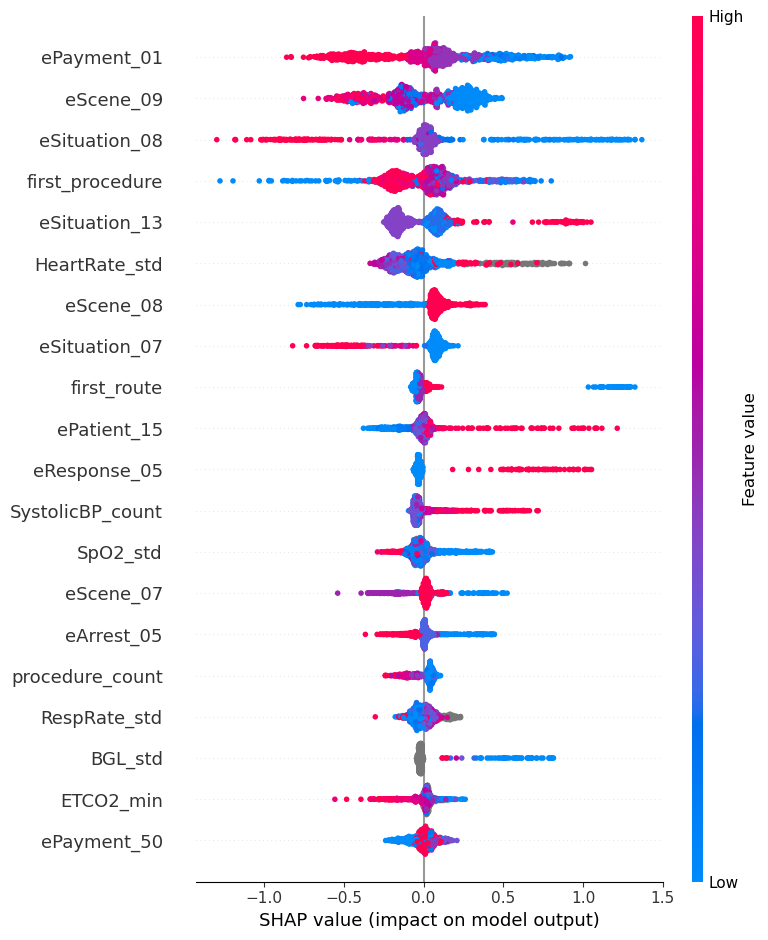

In [29]:
# SHAP summary plot
shap.summary_plot(
    shap_values,
    features=X_test_clean,
    feature_names=X_test_clean.columns
)

In [30]:
# Initialize JS visualization
shap.initjs()

# Pick an example index (you can change this)
example_idx = 88

# Create force plot
shap.force_plot(
    explainer.expected_value,
    shap_values[example_idx],
    features=X_test_clean.iloc[example_idx],
    feature_names=X_test_clean.columns
)


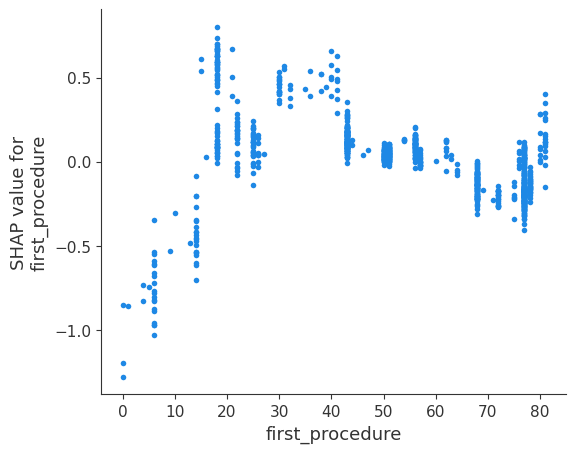

In [31]:
shap.dependence_plot(
    "first_procedure",
    shap_values,
    X_test_clean,
    interaction_index=None,
    show=True
)


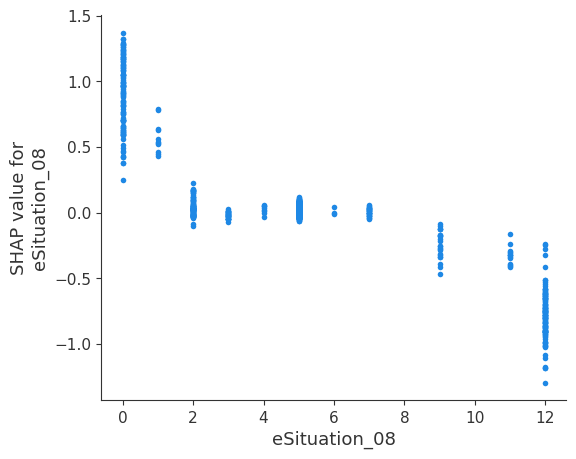

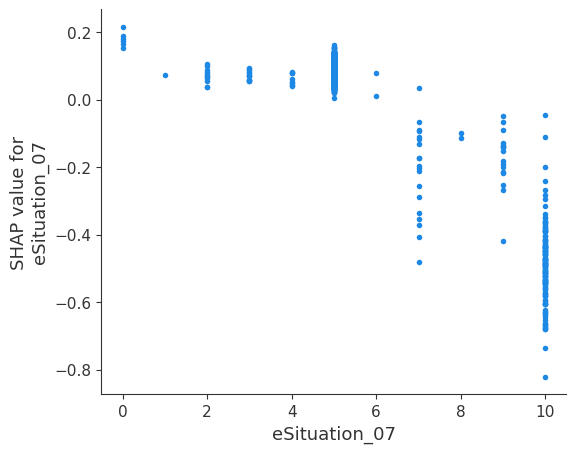

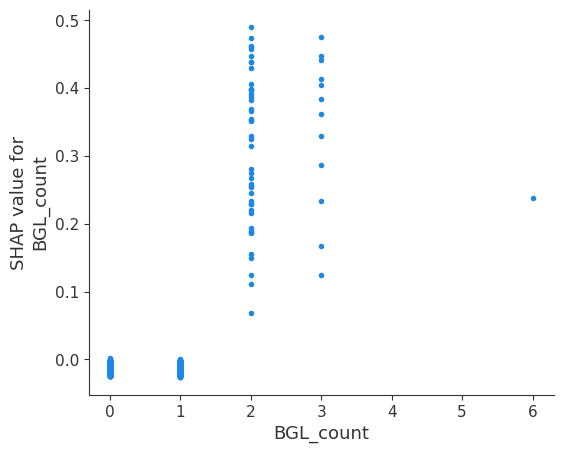

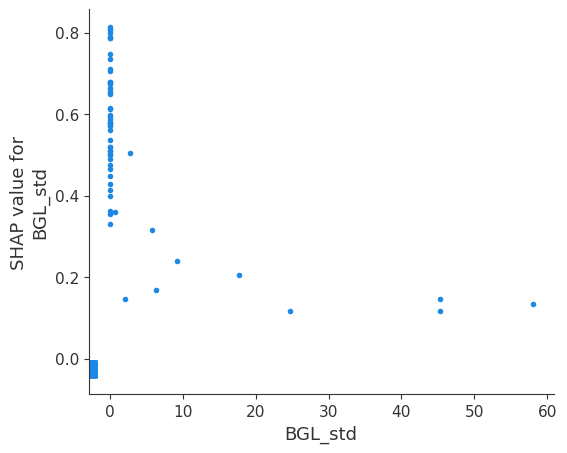

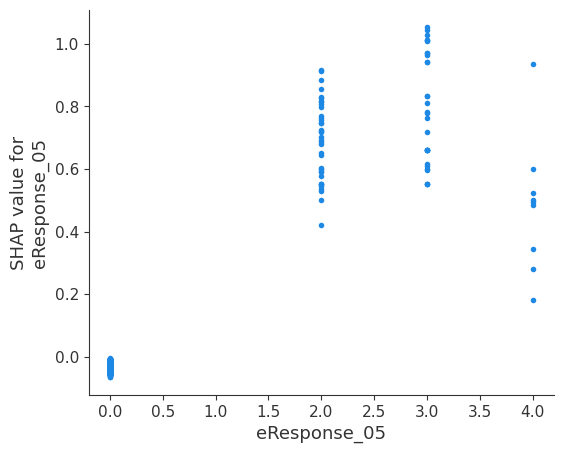

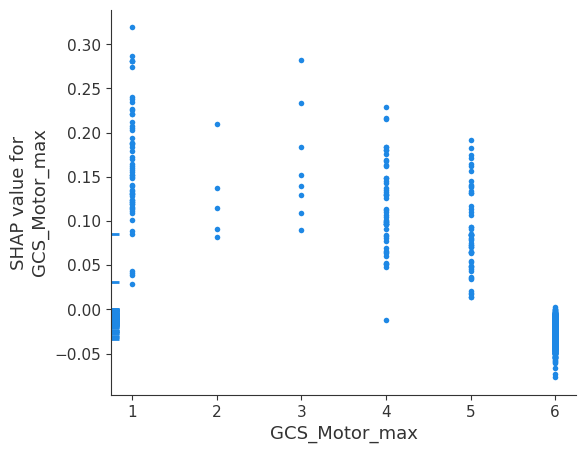

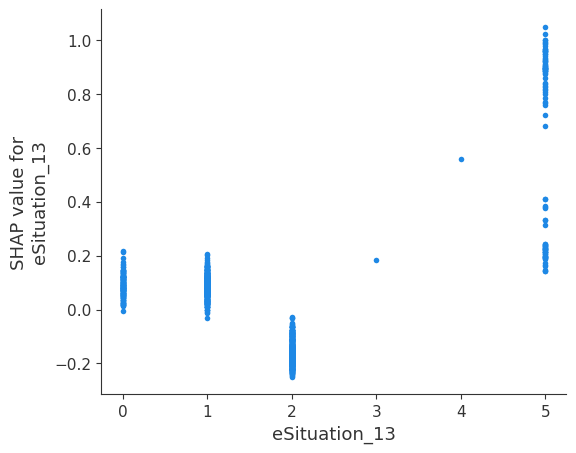

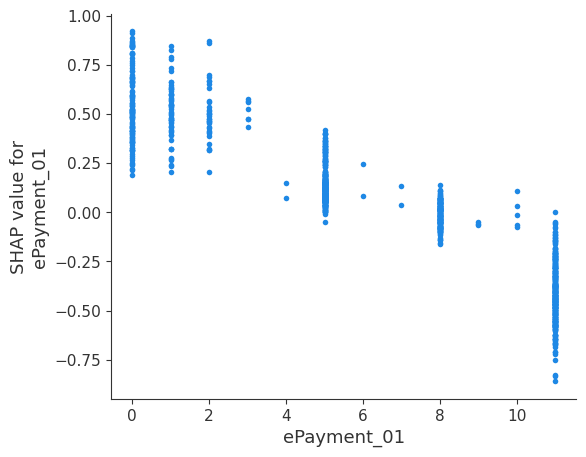

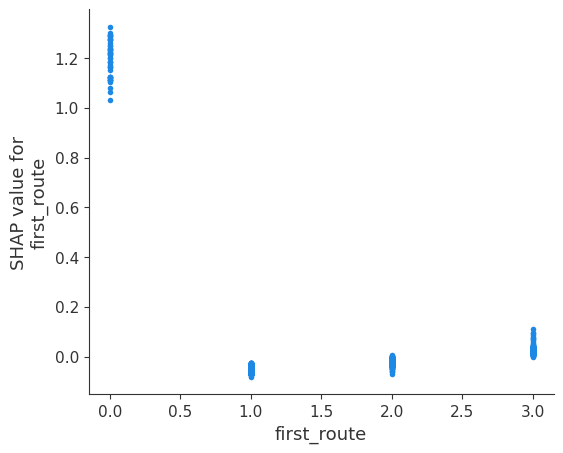

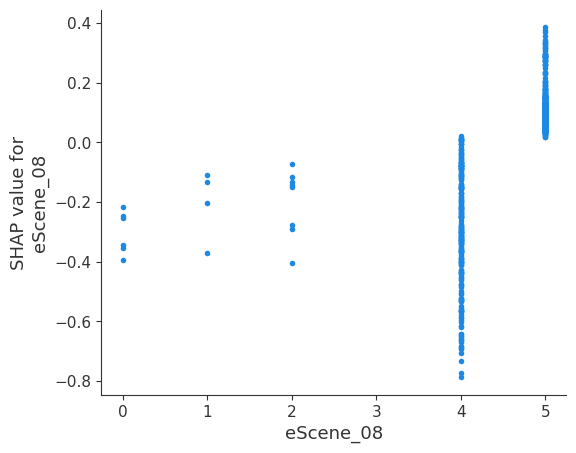

In [32]:
top_features = importances_clean.head(10).index.tolist()

for feat in top_features:
    shap.dependence_plot(
        feat,
        shap_values,
        X_test_clean,
        interaction_index=None,
        show=True
    )


In [33]:
def load_nemsis_mapping(file_path, code_col, desc_col):
    ref = pd.read_csv(file_path, delimiter="|", dtype=str)
    ref.columns = ref.columns.str.strip(" ~'")
    ref[code_col] = ref[code_col].str.strip(" ~")
    ref[desc_col] = ref[desc_col].str.strip(" ~")
    return dict(zip(ref[code_col], ref[desc_col]))

In [34]:
procedure_mapping = load_nemsis_mapping(
    "../data/raw/EPROCEDURES_03REF.txt",
    code_col="eProcedures_03",
    desc_col="ProcedureCodeDescr"
)



In [35]:
raw_code = label_encoders["first_procedure"].classes_[43].strip(" ~")

In [36]:
description = procedure_mapping.get(raw_code, "Unknown code")


In [37]:
print(description)

Catheterization of vein (procedure)


In [38]:
def summarize_shap_by_category(
    feature_name,
    shap_values,
    X,
    label_encoders,
    mapping_dict=None
):
    """
    Returns a DataFrame showing mean SHAP values per category of a categorical feature.
    
    Parameters:
    - feature_name: column name
    - shap_values: full SHAP values array
    - X: X_test DataFrame
    - label_encoders: dict of LabelEncoders
    - mapping_dict: {code: description}
    """
    if feature_name not in label_encoders:
        raise ValueError("Feature is not label-encoded.")
    
    le = label_encoders[feature_name]
    
    # Extract the SHAP column index
    feature_idx = list(X.columns).index(feature_name)
    
    # Pull all encoded values in test set
    encoded_values = X[feature_name]
    
    # For each unique code, compute mean SHAP
    summary = []
    for code in sorted(encoded_values.unique()):
        mask = encoded_values == code
        mean_shap = shap_values[mask, feature_idx].mean()
        
        raw_code = le.classes_[int(code)].strip(" ~")
        description = ""
        if mapping_dict:
            description = mapping_dict.get(raw_code, "")
        
        summary.append({
            "EncodedValue": code,
            "RawCode": raw_code,
            "Description": description,
            "MeanSHAP": mean_shap
        })
    
    df_summary = pd.DataFrame(summary).sort_values("MeanSHAP", ascending=False)
    return df_summary


In [39]:
summary_df = summarize_shap_by_category(
    feature_name="first_procedure",
    shap_values=shap_values,
    X=X_test_clean,
    label_encoders=label_encoders,
    mapping_dict=procedure_mapping
)

print(summary_df)


    EncodedValue    RawCode  \
9             15  232664002   
18            31     353008   
24            40  386339009   
12            21  252465000   
22            38  386053000   
21            36  385857005   
25            41  386423001   
23            39  386220001   
17            30   33747003   
20            35  385756009   
19            32  371907003   
11            18   23852006   
48            81    Unknown   
13            22  268400002   
26            43  392230005   
32            54  423895006   
47            80   89666000   
27            44  392231009   
33            56  425447009   
14            25  302789003   
36            62  428803005   
29            47  408852001   
15            26  304562007   
31            51  422618004   
16            27  304577004   
28            46  405427009   
30            50  422440002   
44            76    7701001   
37            63  429283006   
10            16  232674004   
34            57  425543005   
35      

In [40]:
summarize_shap_by_category(
    feature_name="eScene_09",
    shap_values=shap_values,
    X=X_test_clean,
    label_encoders=label_encoders,
    mapping_dict=scene_09_mapping
)

NameError: name 'scene_09_mapping' is not defined

In [41]:
# Just to confirm which column names you have
print(df.columns.tolist())


['PcrKey', 'eDispatch_01', 'eDispatch_02', 'eArrest_14', 'eArrest_01', 'eArrest_02', 'eArrest_05', 'eArrest_07', 'eArrest_11', 'eArrest_16', 'eArrest_18', 'eDisposition_12', 'eDisposition_19', 'eDisposition_16', 'eDisposition_21', 'eDisposition_22', 'eDisposition_23', 'eOutcome_01', 'eOutcome_02', 'ePatient_15', 'ePatient_16', 'ePayment_01', 'ePayment_50', 'eResponse_05', 'eResponse_07', 'eResponse_15', 'eResponse_23', 'eScene_01', 'eScene_06', 'eScene_07', 'eScene_08', 'eScene_09', 'eSituation_02', 'eSituation_07', 'eSituation_08', 'eSituation_13', 'eSituation_01', 'eTimes_01', 'eTimes_03', 'eTimes_05', 'eTimes_06', 'eTimes_07', 'eTimes_09', 'eTimes_11', 'eTimes_12', 'eTimes_13', 'eDisposition_17', 'HeartRate_first', 'HeartRate_last', 'HeartRate_min', 'HeartRate_max', 'HeartRate_mean', 'HeartRate_std', 'HeartRate_count', 'RespRate_first', 'RespRate_last', 'RespRate_min', 'RespRate_max', 'RespRate_mean', 'RespRate_std', 'RespRate_count', 'SystolicBP_first', 'SystolicBP_last', 'Systolic

In [42]:
# Show unique values in that field
df["eSituation_08"].unique()


array(['2808011', '2808007', '2808005', '2808009', '7701003', '2808019',
       '2808003', '2808015', '2808001', '7701001', '2808013', '2808021',
       '2808017'], dtype=object)

In [43]:
def summarize_shap_by_category(
    feature_name,
    shap_values,
    X,
    label_encoders,
    mapping_dict=None
):
    """
    Returns a DataFrame showing mean SHAP values per category of a categorical feature.
    """
    if feature_name not in label_encoders:
        raise ValueError("Feature is not label-encoded.")
    
    le = label_encoders[feature_name]
    
    # Get column index
    feature_idx = list(X.columns).index(feature_name)
    
    encoded_values = X[feature_name]
    
    summary = []
    for code in sorted(encoded_values.unique()):
        mask = encoded_values == code
        mean_shap = shap_values[mask, feature_idx].mean()
        
        raw_code = le.classes_[int(code)].strip(" ~")
        desc = ""
        if mapping_dict:
            desc = mapping_dict.get(raw_code, "")
        
        summary.append({
            "EncodedValue": code,
            "RawCode": raw_code,
            "Description": desc,
            "MeanSHAP": mean_shap
        })
    
    df_summary = pd.DataFrame(summary).sort_values("MeanSHAP", ascending=False)
    return df_summary


In [44]:
summary_eSituation_08 = summarize_shap_by_category(
    feature_name="eSituation_08",
    shap_values=shap_values,
    X=X_test_clean,
    label_encoders=label_encoders,
    mapping_dict=eSituation_08_mapping
)

print(summary_eSituation_08)


    EncodedValue  RawCode             Description  MeanSHAP
0              0  2808001  Behavioral/Psychiatric  0.911347
1              1  2808003          Cardiovascular  0.575733
2              2  2808005               CNS/Neuro  0.041165
4              4  2808009                      GI  0.023284
5              5  2808011          Global/General  0.018484
6              6  2808013        Lymphatic/Immune  0.010794
7              7  2808015    Musculoskeletal/Skin  0.006603
3              3  2808007     Endocrine/Metabolic -0.020165
8              9  2808019               Pulmonary -0.242952
9             11  7701001          Not Applicable -0.325309
10            12  7701003            Not Recorded -0.774139


In [45]:
top_categorical_features = [
    "eSituation_08",
    "eSituation_07",
    "eResponse_05",
    "eSituation_13",
    "ePayment_01",
    "first_route",
    "eScene_08",
    "eArrest_02",
    "eArrest_05",
    "eScene_06",
    "ePayment_50"
]

# Mapping dicts
mapping_dicts = {
    "eSituation_08": eSituation_08_mapping,
    "eSituation_07": eSituation_07_mapping,
    "eResponse_05": eResponse_05_mapping,
    "eSituation_13": eSituation_13_mapping,
    "ePayment_01": ePayment_01_mapping,
    "first_route": first_route_mapping,
    "eScene_08": eScene_08_mapping,
    "eArrest_02": eArrest_02_mapping,
    "eArrest_05": eArrest_05_mapping,
    "eScene_06": eScene_06_mapping,
    "ePayment_50": ePayment_50_mapping
}

# Dictionary to hold results
feature_summaries = {}

# Loop through features
for feature in top_categorical_features:
    if feature in label_encoders:
        mapping = mapping_dicts.get(feature, None)
        summary = summarize_shap_by_category(
            feature_name=feature,
            shap_values=shap_values,
            X=X_test_clean,
            label_encoders=label_encoders,
            mapping_dict=mapping
        )
        feature_summaries[feature] = summary
        print(f"Summary created for {feature}.")
    else:
        print(f"Skipping {feature} (not label-encoded).")


Summary created for eSituation_08.
Summary created for eSituation_07.
Summary created for eResponse_05.
Summary created for eSituation_13.
Summary created for ePayment_01.
Summary created for first_route.
Summary created for eScene_08.
Summary created for eArrest_02.
Summary created for eArrest_05.
Summary created for eScene_06.
Summary created for ePayment_50.


In [46]:
feature_summaries["eSituation_08"]


,EncodedValue,RawCode,Description,MeanSHAP
0,0,2808001,Behavioral/Psychiatric,0.911347
1,1,2808003,Cardiovascular,0.575733
2,2,2808005,CNS/Neuro,0.041165
4,4,2808009,GI,0.023284
5,5,2808011,Global/General,0.018484
6,6,2808013,Lymphatic/Immune,0.010794
7,7,2808015,Musculoskeletal/Skin,0.006603
3,3,2808007,Endocrine/Metabolic,-0.020165
8,9,2808019,Pulmonary,-0.242952
9,11,7701001,Not Applicable,-0.325309


In [47]:
feature_summaries["eSituation_07"]

,EncodedValue,RawCode,Description,MeanSHAP
0,0,2807001,Abdomen,0.180053
5,5,2807011,General/Global,0.081225
3,3,2807007,Extremity-Lower,0.073926
1,1,2807003,Back,0.073823
2,2,2807005,Chest,0.072346
4,4,2807009,Extremity-Upper,0.061328
6,6,2807013,Genitalia,0.045702
8,8,2807017,Neck,-0.105069
9,9,7701001,Not Applicable,-0.175138
7,7,2807015,Head,-0.210796


In [48]:
feature_summaries["eResponse_05"]


,EncodedValue,RawCode,Description,MeanSHAP
2,3,2205007,Medical Transport,0.794726
1,2,2205005,Interfacility Transport,0.692623
3,4,2205009,Mutual Aid,0.483188
0,0,2205001,911 Response (Scene),-0.030773


In [49]:
feature_summaries["eSituation_13"]

,EncodedValue,RawCode,Description,MeanSHAP
5,5,7701003,Not Recorded,0.617356
4,4,7701001,Not Applicable,0.559887
3,3,2813007,Dead without Resuscitation,0.183909
0,0,2813001,Critical (Red),0.090788
1,1,2813003,Emergent (Yellow),0.086934
2,2,2813005,Lower Acuity (Green),-0.161515


In [50]:
feature_summaries["ePayment_01"]


,EncodedValue,RawCode,Description,MeanSHAP
0,0,2601001,Insurance,0.542783
3,3,2601007,Not Billed,0.515570
1,1,2601003,Medicaid,0.512186
2,2,2601005,Medicare,0.506558
6,6,2601015,Payment by Facility,0.164164
5,5,2601011,Self Pay,0.139607
4,4,2601009,Other Government,0.109780
7,7,2601019,Community Network,0.085275
10,10,7701001,Not Applicable,-0.002317
8,8,2601021,No Insurance Identified,-0.008611


In [51]:
feature_summaries["eScene_08"]


,EncodedValue,RawCode,Description,MeanSHAP
4,5,7701003,Not Recorded,0.095681
2,2,2708005,Green - Minimal (Minor),-0.197535
1,1,2708003,Yellow - Delayed,-0.203486
3,4,7701001,Not Applicable,-0.289638
0,0,2708001,Red - Immediate,-0.301709


In [52]:
feature_summaries["eArrest_02"]


,EncodedValue,RawCode,Description,MeanSHAP
1,1,3002005,Drug Overdose,0.199658
0,0,3002001,Cardiac (Presumed),0.164598
2,2,3002011,Other,0.163895
4,5,7701003,Not Recorded,-0.002926
3,4,7701001,Not Applicable,-0.006441


In [53]:
feature_summaries["eArrest_05"]


,EncodedValue,RawCode,Description,MeanSHAP
0,0,7701001,Not Applicable,0.262285
2,2,9923001,No,0.054185
3,3,9923003,Yes,0.038129
1,1,7701003,Not Recorded,0.012350
4,4,Unknown,,-0.097262


In [54]:
feature_summaries["eScene_06"]


,EncodedValue,RawCode,Description,MeanSHAP
1,2,2707005,Single,0.007086
0,0,2707001,Multiple,0.007014
2,4,7701003,Not Recorded,-0.401294


In [55]:
feature_summaries["ePayment_50"]


,EncodedValue,RawCode,Description,MeanSHAP
5,6,2650015,Specialty Care Transport,0.151078
3,3,2650007,BLS,0.089620
4,4,2650009,"BLS, Emergency",0.056264
2,2,2650005,"ALS, Level 2",0.050351
1,1,2650003,"ALS, Level 1 Emergency",0.030960
7,9,7701003,Not Recorded,0.009720
6,8,7701001,Not Applicable,-0.002510
0,0,2650001,"ALS, Level 1",-0.084141


/var/folders/qs/svfy8y496zs3ryjhvjm063340000gn/T/ipykernel_32570/3681769941.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


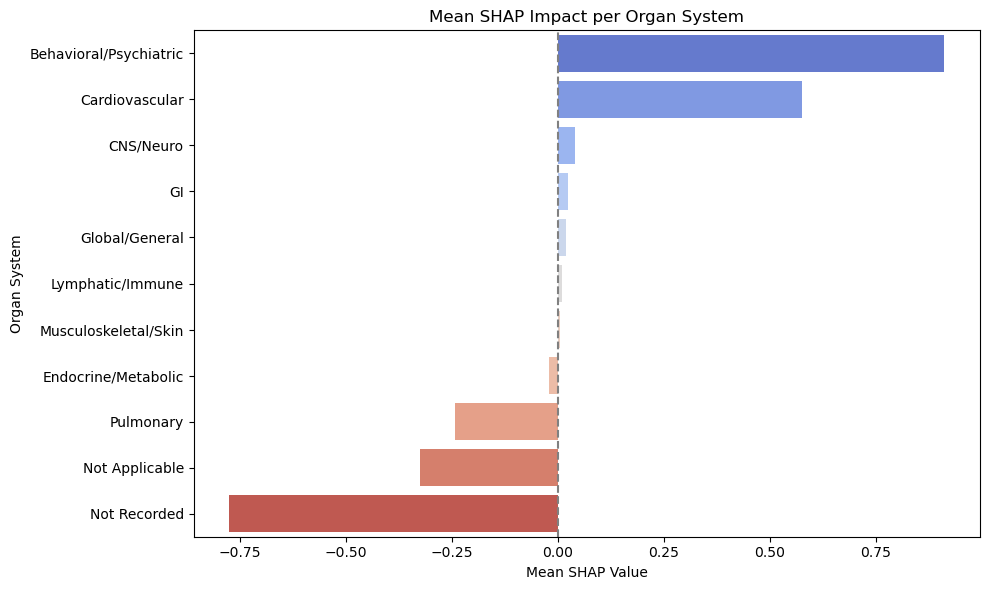

In [56]:
import matplotlib.pyplot as plt

df = feature_summaries["eSituation_08"]

plt.figure(figsize=(10,6))
sns.barplot(
    data=df,
    y="Description",
    x="MeanSHAP",
    palette="coolwarm",
    orient="h"
)
plt.title("Mean SHAP Impact per Organ System")
plt.xlabel("Mean SHAP Value")
plt.ylabel("Organ System")
plt.axvline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()


In [57]:
import os
raw_dir = "../data/raw/"
files = sorted(os.listdir(raw_dir))
for f in files:
    print(f)


.ipynb_checkpoints
ComputedElements.txt
EINJURY_01REF.txt
EPROCEDURES_03REF.txt
ESITUATION_09REF.txt
ESITUATION_10REF.txt
ESITUATION_11REF.txt
ESITUATION_12REF.txt
FACTPCRADDITIONALRESPONSEMODE.txt
FACTPCRADDITIONALSYMPTOM.txt
FACTPCRADDITIONALTRANSPORTMODE.txt
FACTPCRALCOHOLDRUGUSEINDICATOR.txt
FACTPCRARRESTCPRPROVIDED.txt
FACTPCRARRESTRESUSCITATION.txt
FACTPCRARRESTRHYTHMDESTINATION.txt
FACTPCRARRESTROSC.txt
FACTPCRARRESTWITNESS.txt
FACTPCRBARRIERTOCARE.txt
FACTPCRCAUSEOFINJURY.txt
FACTPCRDESTINATIONREASON.txt
FACTPCRDESTINATIONTEAM.txt
FACTPCRDISPATCHDELAY.txt
FACTPCRINJURYRISKFACTOR.txt
FACTPCRMEDICATION.txt
FACTPCRPRIMARYIMPRESSION.txt
FACTPCRPRIMARYSYMPTOM.txt
FACTPCRPROCEDURE.txt
FACTPCRPROTOCOL.txt
FACTPCRRESPONSEDELAY.txt
FACTPCRSCENEDELAY.txt
FACTPCRSECONDARYIMPRESSION.txt
FACTPCRTRANSPORTDELAY.txt
FACTPCRTRAUMACRITERIA.txt
FACTPCRTURNAROUNDDELAY.txt
FACTPCRVITAL.txt
FACTPCRWORKRELATEDEXPOSURE.txt
PCRMEDCOMPGROUP.txt
PCRPATIENTRACEGROUP.txt
PCRPROCCOMPGROUP.txt
PCRVITALECGGRO